### 데이터 로드 및 전처리

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [54]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(set(y_train)))

6736
2246
2246
46


In [56]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
from tensorflow.keras.preprocessing.sequence import pad_sequences

def one_hot_encoding(data, dim=10000):
    return pad_sequences(data, maxlen=dim)

X_train = one_hot_encoding(X_train)
X_val = one_hot_encoding(X_val)
X_test = one_hot_encoding(X_test)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### 모델 구성 및 컴파일

In [58]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
model = models.Sequential([
    layers.Input(shape=(10_000)),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(46, activation="softmax")
])
      
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [60]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               1280128   
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
activation_18 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
activation_19 (Activation)   (None, 64)               

### 모델 학습

In [62]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint("reuters_model.keras", 
                                   save_best_only=True)
early_stopping = EarlyStopping(patience=10, 
                               monitor="val_loss", 
                               restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=64,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
106/106 [==============================] - 2s 7ms/step - loss: 3.3641 - accuracy: 0.2322 - val_loss: 2.8993 - val_accuracy: 0.4087
Epoch 2/100
106/106 [==============================] - 1s 6ms/step - loss: 2.5472 - accuracy: 0.3980 - val_loss: 2.4629 - val_accuracy: 0.4354
Epoch 3/100
106/106 [==============================] - 1s 6ms/step - loss: 2.4237 - accuracy: 0.4173 - val_loss: 2.3303 - val_accuracy: 0.4435
Epoch 4/100
106/106 [==============================] - 1s 6ms/step - loss: 2.3747 - accuracy: 0.4222 - val_loss: 2.2794 - val_accuracy: 0.4399
Epoch 5/100
106/106 [==============================] - 1s 6ms/step - loss: 2.3362 - accuracy: 0.4213 - val_loss: 2.2484 - val_accuracy: 0.4443
Epoch 6/100
106/106 [==============================] - 1s 6ms/step - loss: 2.3113 - accuracy: 0.4296 - val_loss: 2.2381 - val_accuracy: 0.4452
Epoch 7/100
106/106 [==============================] - 1s 6ms/step - loss: 2.2833 - accuracy: 0.4344 - val_loss: 2.2262 - val_accuracy: 0.4470

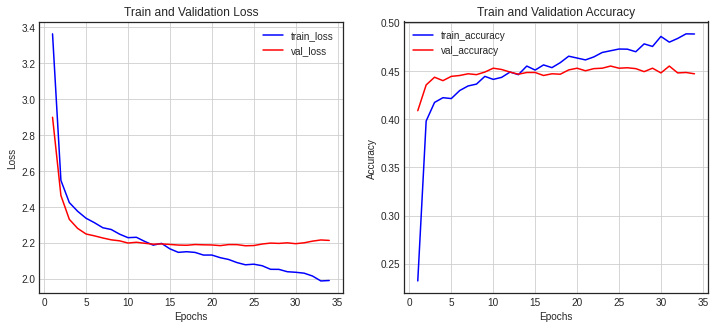

In [64]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 모델 평가 및 예측

In [65]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 2.2115 - accuracy: 0.4408


[2.211493968963623, 0.44078361988067627]